<a href="https://colab.research.google.com/github/cristinarainich/MLTSA22_KRainich/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
# importing data
grbAG = pd.read_csv('https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/main/HW1/grb050525A.csv')
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [183]:
# create the log-time variable
grbAG["logtime"] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


In [8]:
grbAG.columns

Index(['filter', 'time', 'mag', 'magerr', 'upperlimit', 'logtime'], dtype='object')

In [15]:
grbAG['filter'].value_counts()

V     44
U     16
B     16
M2    15
W1    15
W2    13
Name: filter, dtype: int64

Text(0.5, 0, 'log time (sec after explosion)')

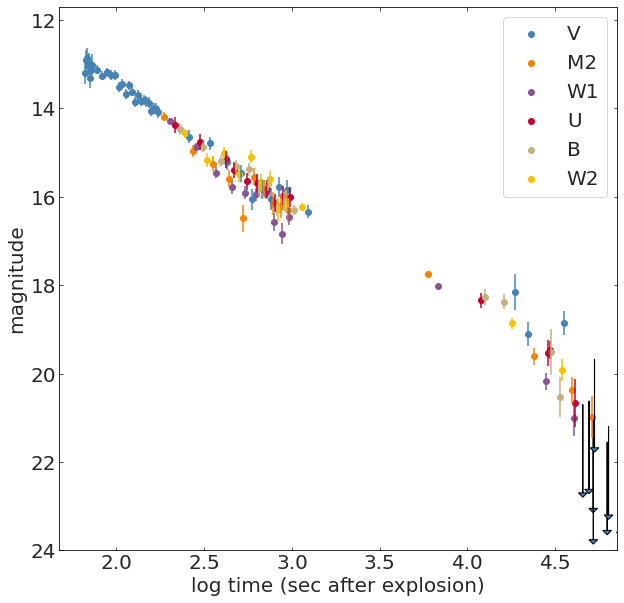

In [194]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
line_name = []
for f in grbAG['filter'].unique():
  pl.errorbar(x = grbAG.loc[grbAG['filter'] == f, 'logtime'], 
              y = grbAG.loc[grbAG['filter'] == f, 'mag'], 
              yerr = grbAG.loc[grbAG['filter'] == f, 'magerr'], ls = '')
  pl.scatter(x = grbAG.loc[grbAG['filter'] == f, 'logtime'],
             y = grbAG.loc[grbAG['filter'] == f, 'mag'], label = f)

for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

pl.ylim(24,11.7)          
pl.legend()

pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20)

In [130]:
x = grbAG.loc[grbAG['upperlimit'] == 0, 'logtime']
X = np.c_[np.ones((len(grbAG.loc[grbAG['upperlimit'] == 0]), 1)), x]
y = grbAG.loc[grbAG['upperlimit'] == 0, 'mag']
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)

shape of the input array X (108, 2)
shape of the input array y (108,)


In [131]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


In [132]:
lr = LinearRegression()
lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


In [149]:
# L1 with abs
def line(x, intercept, slope):
  return slope * x + intercept

def l1(args, x, y):
  a, b = args
  return sum(abs(line(x, b, a) - y))

initialGuess = (10, 1)
l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.304340597340804
 hess_inv: array([[ 0.00759366, -0.01591281],
       [-0.01591281,  0.03413314]])
      jac: array([-1.95810866,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 271
      nit: 11
     njev: 66
   status: 2
  success: False
        x: array([2.64023314, 8.22681691])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [147]:
def chi2(args, x, y, s):
  a, b = args
  return sum((line(x, b, a) - y)**2 / s)

s = grbAG.loc[grbAG['upperlimit'] == 0, 'magerr']
initialGuess = (10, 1)
chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 58.4983742894839
 hess_inv: array([[ 0.00139784, -0.00381294],
       [-0.00381294,  0.01113153]])
      jac: array([2.86102295e-06, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([2.49968626, 8.58159554])

best fit parameters from the minimization of the chi squared: slope 2.50, intercept 8.58


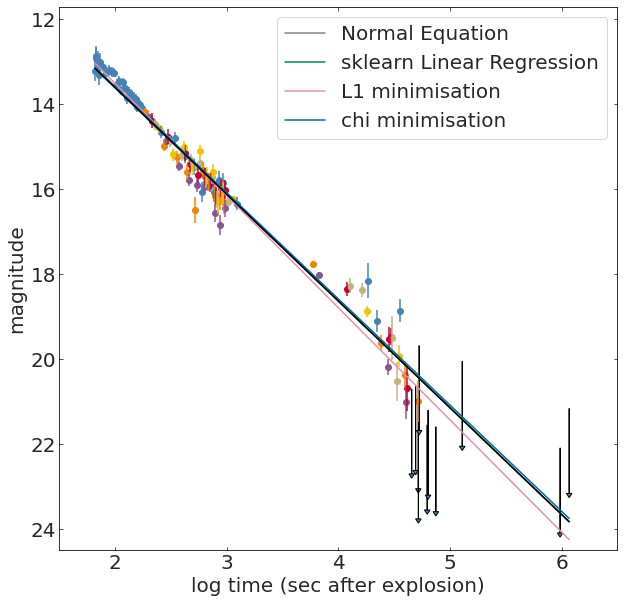

In [197]:
def plotline(a, b, modelname):
  ax.plot(grbAG['logtime'], a + b * grbAG['logtime'], label = modelname)


ax = pl.figure(figsize=(10,10)).add_subplot(111)
for f in grbAG['filter'].unique():
  pl.errorbar(x = grbAG.loc[grbAG['filter'] == f, 'logtime'], 
              y = grbAG.loc[grbAG['filter'] == f, 'mag'], 
              yerr = grbAG.loc[grbAG['filter'] == f, 'magerr'], ls = '')
  pl.scatter(x = grbAG.loc[grbAG['filter'] == f, 'logtime'],
             y = grbAG.loc[grbAG['filter'] == f, 'mag'])

for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

#normal equation
plotline(theta_best[0], theta_best[1], 'Normal Equation')
         
#sklearn
plotline(lr.intercept_, lr.coef_[1], 'sklearn Linear Regression')
         
#minimize L1
plotline(l1Solution.x[1], l1Solution.x[0], 'L1 minimisation')
         
#minimize chi2
plotline(chi2Solution.x[1], chi2Solution.x[0], 'chi minimisation')

pl.legend()

pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);